In [1]:
import pandas as pd
import os
import glob

# Define the path pattern to search for CSV files
path_pattern = '../../Data/Data_Exploration/descriptive_stats_*.csv'

# Find all CSV files matching the pattern
csv_files = glob.glob(path_pattern)

# Initialize dictionaries to store correlations by type
correlations_data = {}

# Process each CSV file
for file_path in csv_files:
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Check if R2_ros_p column exists
        if 'R2_ros_p' in df.columns:
            # Extract filename to determine type
            filename = os.path.basename(file_path)
            
            # Determine model type and transformation
            if 'model' in filename.lower() and 'log' in filename.lower():
                col_suffix = 'model_log'
            elif 'model' in filename.lower():
                col_suffix = 'model'
            elif 'final' in filename.lower() and 'log' in filename.lower():
                col_suffix = 'final_log'
            elif 'final' in filename.lower():
                col_suffix = 'final'
            else:
                print(f"Warning: Could not determine type for {filename}")
                continue
            
            # Extract variable names and R2_ros_p values
            for idx, row in df.iterrows():
                if pd.notna(row['R2_ros_p']):
                    variable_name = df.iloc[idx, 0]  # First column contains variable names
                    
                    # Initialize variable entry if not exists
                    if variable_name not in correlations_data:
                        correlations_data[variable_name] = {'variable': variable_name}
                    
                    # Add correlation value for this file type
                    correlations_data[variable_name][f'R2_ros_p_{col_suffix}'] = row['R2_ros_p']
                    
        else:
            print(f"Warning: R2_ros_p column not found in {file_path}")
            
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

# Create DataFrame from collected correlations
if correlations_data:
    # Convert dictionary to DataFrame
    correlations_df = pd.DataFrame(correlations_data.values())
    
    # Reorder columns to match your desired structure
    desired_columns = ['variable', 'R2_ros_p_model', 'R2_ros_p_model_log', 
                       'R2_ros_p_final', 'R2_ros_p_final_log']
    
    # Add missing columns with NaN values if they don't exist
    for col in desired_columns:
        if col not in correlations_df.columns:
            correlations_df[col] = None
    
    # Reorder columns
    correlations_df = correlations_df[desired_columns]
    
    # Save to new CSV file
    output_file = '../../Data/Data_Exploration/all_ros_p_correlations.csv'
    correlations_df.to_csv(output_file, index=False)
    
    print(f"Successfully created {output_file}")
    print(f"Total variables: {len(correlations_df)}")
    print(f"Files processed: {len(csv_files)}")
    print(f"\nDataFrame structure:")
    print(correlations_df.head())
    
else:
    print("No correlation data found in any of the files")

Successfully created ../../Data/Data_Exploration/all_ros_p_correlations.csv
Total variables: 104
Files processed: 2

DataFrame structure:
     variable  R2_ros_p_model  R2_ros_p_model_log R2_ros_p_final  \
0  1_3y_fir_p        0.002981            0.112848           None   
1  3_8y_fir_p        0.000166            0.032336           None   
2  8_ny_fir_p        0.002431            0.002648           None   
3    BLH_m_av        0.027352            0.068334           None   
4    BLH_m_rt        0.002414            0.001685           None   

  R2_ros_p_final_log  
0               None  
1               None  
2               None  
3               None  
4               None  


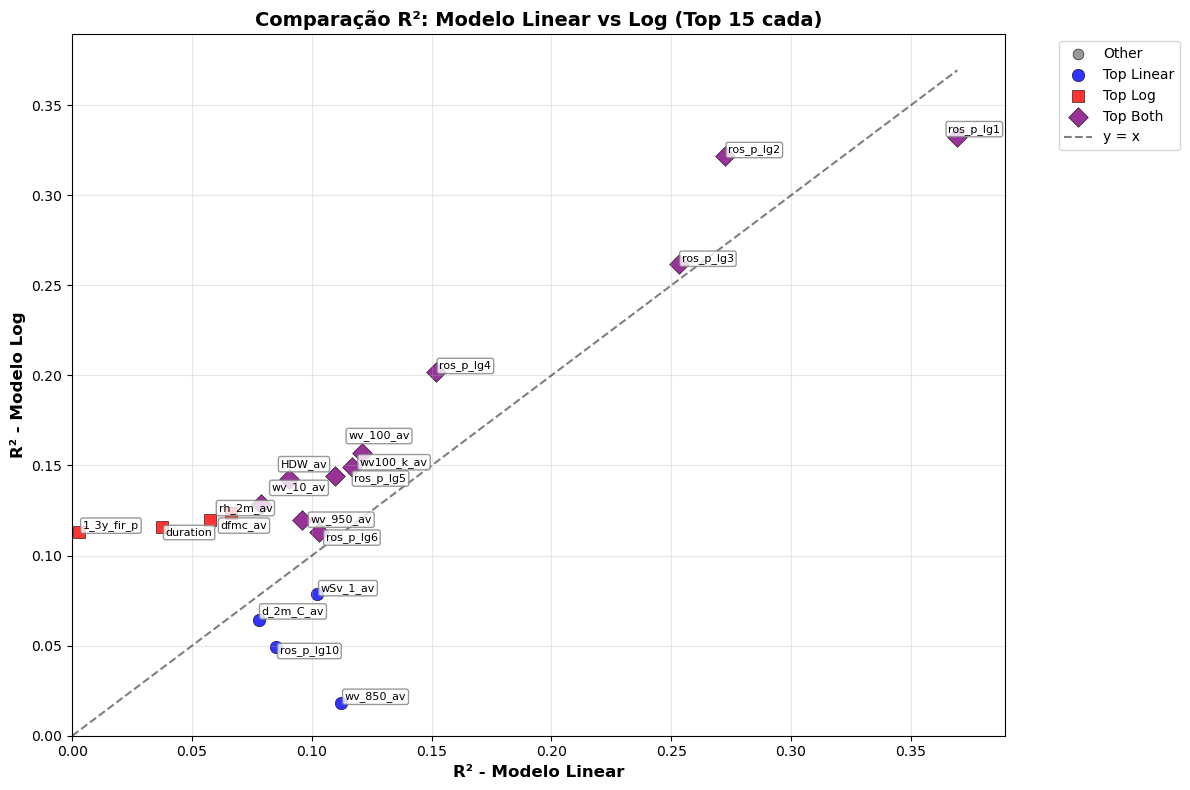

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

# Lendo o arquivo CSV
df = pd.read_csv('..\\..\\Data\\Data_Exploration\\all_ros_p_correlations.csv')

# Ordenando pelos maiores R² para cada modelo
top15_linear = df.nlargest(15, 'R2_ros_p_model')[['variable', 'R2_ros_p_model']]
top15_log = df.nlargest(15, 'R2_ros_p_model_log')[['variable', 'R2_ros_p_model_log']]

# Juntando todos os candidatos únicos
all_top_vars = set(top15_linear['variable']).union(set(top15_log['variable']))
comparison_data = df[df['variable'].isin(all_top_vars)]

# Classificando os pontos
comparison_data = comparison_data.copy()
comparison_data['category'] = 'Other'
comparison_data.loc[comparison_data['variable'].isin(top15_linear['variable']), 'category'] = 'Top Linear'
comparison_data.loc[comparison_data['variable'].isin(top15_log['variable']), 'category'] = 'Top Log'
comparison_data.loc[comparison_data['variable'].isin(top15_linear['variable']) & 
                   comparison_data['variable'].isin(top15_log['variable']), 'category'] = 'Top Both'

# Criando scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Definindo cores e marcadores para cada categoria
colors = {'Top Linear': 'blue', 'Top Log': 'red', 'Top Both': 'purple', 'Other': 'gray'}
markers = {'Top Linear': 'o', 'Top Log': 's', 'Top Both': 'D', 'Other': 'o'}
sizes = {'Top Linear': 80, 'Top Log': 80, 'Top Both': 100, 'Other': 60}

# Plotando cada categoria separadamente
for category in ['Other', 'Top Linear', 'Top Log', 'Top Both']:
    cat_data = comparison_data[comparison_data['category'] == category]
    ax.scatter(cat_data['R2_ros_p_model'], 
               cat_data['R2_ros_p_model_log'], 
               alpha=0.8, s=sizes[category],
               c=colors[category], marker=markers[category],
               label=category, edgecolors='black', linewidth=0.5)

# Linha de igualdade
max_val = max(comparison_data[['R2_ros_p_model', 'R2_ros_p_model_log']].max().max(), 0.15)
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='y = x')

ax.set_xlabel('R² - Modelo Linear', fontsize=12, fontweight='bold')
ax.set_ylabel('R² - Modelo Log', fontsize=12, fontweight='bold')
ax.set_title('Comparação R²: Modelo Linear vs Log (Top 15 cada)', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)

# SOLUÇÃO: Usar adjust_text sem arrowprops ou com configurações específicas
texts = []
for i, row in comparison_data.iterrows():
    if row['category'] in ['Top Linear', 'Top Log', 'Top Both']:
        text = ax.annotate(row['variable'], 
                          (row['R2_ros_p_model'], row['R2_ros_p_model_log']),
                          fontsize=8,
                          bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))
        texts.append(text)

# Opção 1: Sem arrowprops (mais simples)
adjust_text(texts,
            expand_points=(1.5, 1.5),
            expand_text=(1.2, 1.2), 
            force_points=0.5,
            force_text=0.5,
            lim=1000)

plt.xlim(0, max_val + 0.02)
plt.ylim(0, max_val + 0.02)
plt.tight_layout()
plt.show()